# main

A larger squirmer is used to test whether oscillations are lattice artifacts.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import copy
import auxiliary3 as aux

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os
import re

%reload_ext autoreload
%autoreload 2

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [127]:
# output directory
src_n = 33
dataDir = f'../data.lbm/{src_n}/'
# dataDir = f'../src/{src_n}/output.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dataDir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

len(ticks)

502

# Fluid

In [128]:
# id += 1
id = -1
fluidDf = pd.read_csv(dataDir + f"fluidTrj_{ticks[id]}.csv").set_index(["id_x","id_y"]).sort_index()

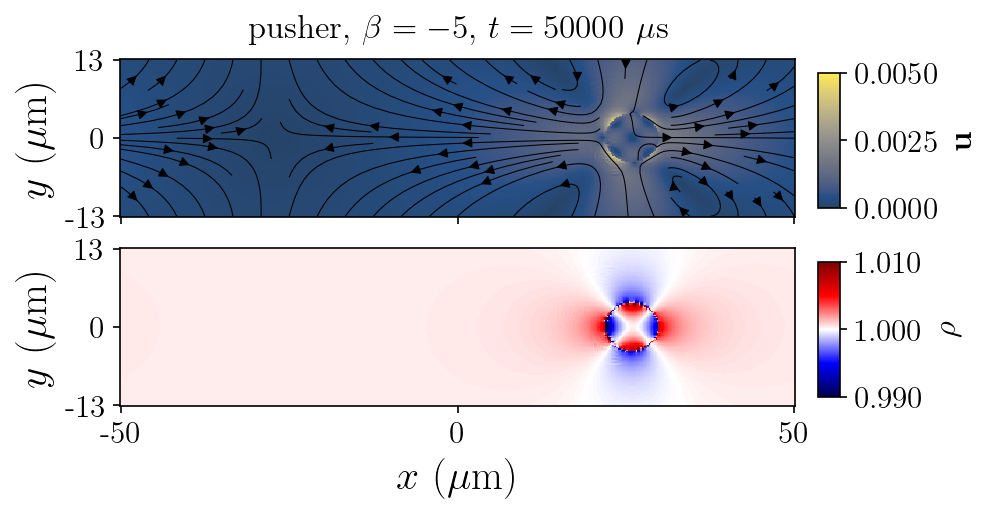

In [129]:
title = "pusher, $\\beta = -5,$ "+f"$t = {fluidDf.time.values[0]:.0f}$"+" $\\mu \\mathrm{s}$"
fig, axes = aux.fluidOverview(fluidDf.query("coordinate_x**2 <= 50**2 & coordinate_y**2 <= 13**2"), title)
# plt.savefig("figure1.png", format="png", transparent=True, dpi=1000, bbox_inches="tight")
plt.show()

# Particle

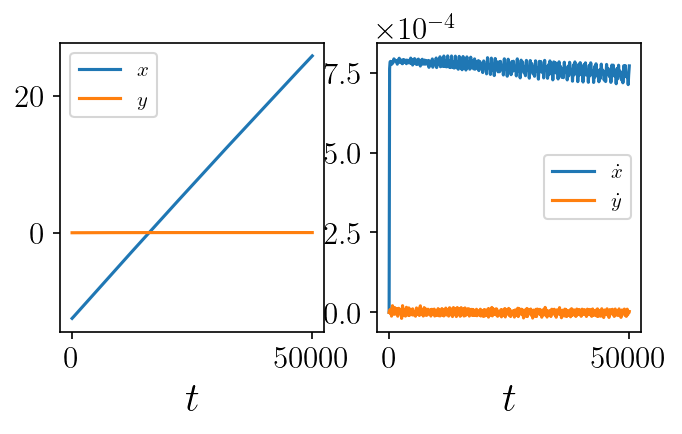

In [130]:
particleDf = pd.read_csv(dataDir+"particlesTrj.csv")
fig, axes = aux.particleTrjOverview(particleDf)
plt.show()

## particle velocity is compared to analytical results

For a squirmer traveling towards $\mathbf{\hat{e}}$, its velocity will be given by
$$
    \mathbf{v} = \frac{2}{3} B_1 \mathbf{\hat{e}}
$$

The squirmer shown here is set to swim towards $\mathbf{\hat{x}}$.

In [131]:
flux_x = fluidDf.query('coordinate_x == -50').fluidVelocity_x.mean()
flux_y = fluidDf.query('coordinate_x == -50').fluidVelocity_y.mean()

stableTime = 1000
vAvgX = particleDf.query(f'time >= {stableTime}').velocity_x.mean()
vAvgY = particleDf.query(f'time >= {stableTime}').velocity_y.mean()

particleVelocityLabFrame = [vAvgX - flux_x, vAvgY - flux_y]
particleVelocityLabFrame # μm/μs

[np.float64(0.0008098709805598951), np.float64(1.1039299691901507e-06)]

In [132]:
expectedSpeed = 1e-3
relativeError = np.abs(expectedSpeed - np.linalg.norm(particleVelocityLabFrame))/expectedSpeed
relativeError

np.float64(0.19012826706050373)

# Stability analysis

In [133]:
def avgSpeed(df):
    return np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).mean()

In [134]:
try:
    avgFluidSpeed 
except NameError:
    avgFluidSpeed = []
    
try:
    time 
except NameError:
    time = []

for tick in ticks[len(time)::]:
    auxDf = pd.read_csv(dataDir + f"fluidTrj_{tick}.csv")
    avgFluidSpeed.append(avgSpeed(auxDf))
    time.append(auxDf.time.values[0])
    print(f'\r{tick}', end='', flush=True)
print('\r'+' '*10, end='', flush=True)

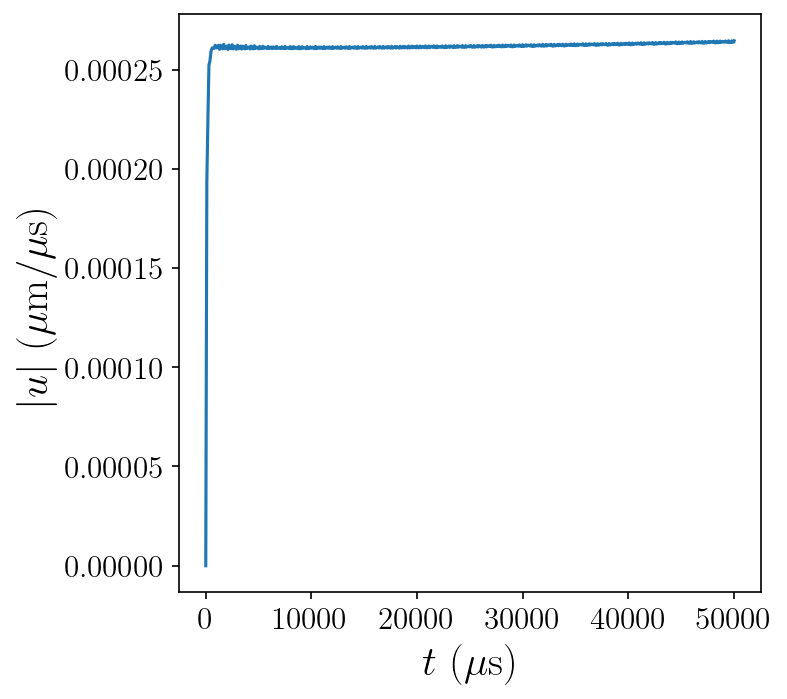

In [135]:
fig, ax = plt.subplots(figsize = (5,5))

ax.plot(time, avgFluidSpeed)
ax.set_xlabel("$t ~ (\\mu \\mathrm{s})$")
ax.set_ylabel("$|u| ~ (\\mu \\mathrm{m} / \\mu \\mathrm{s})$")

plt.show()

# Stress tensor

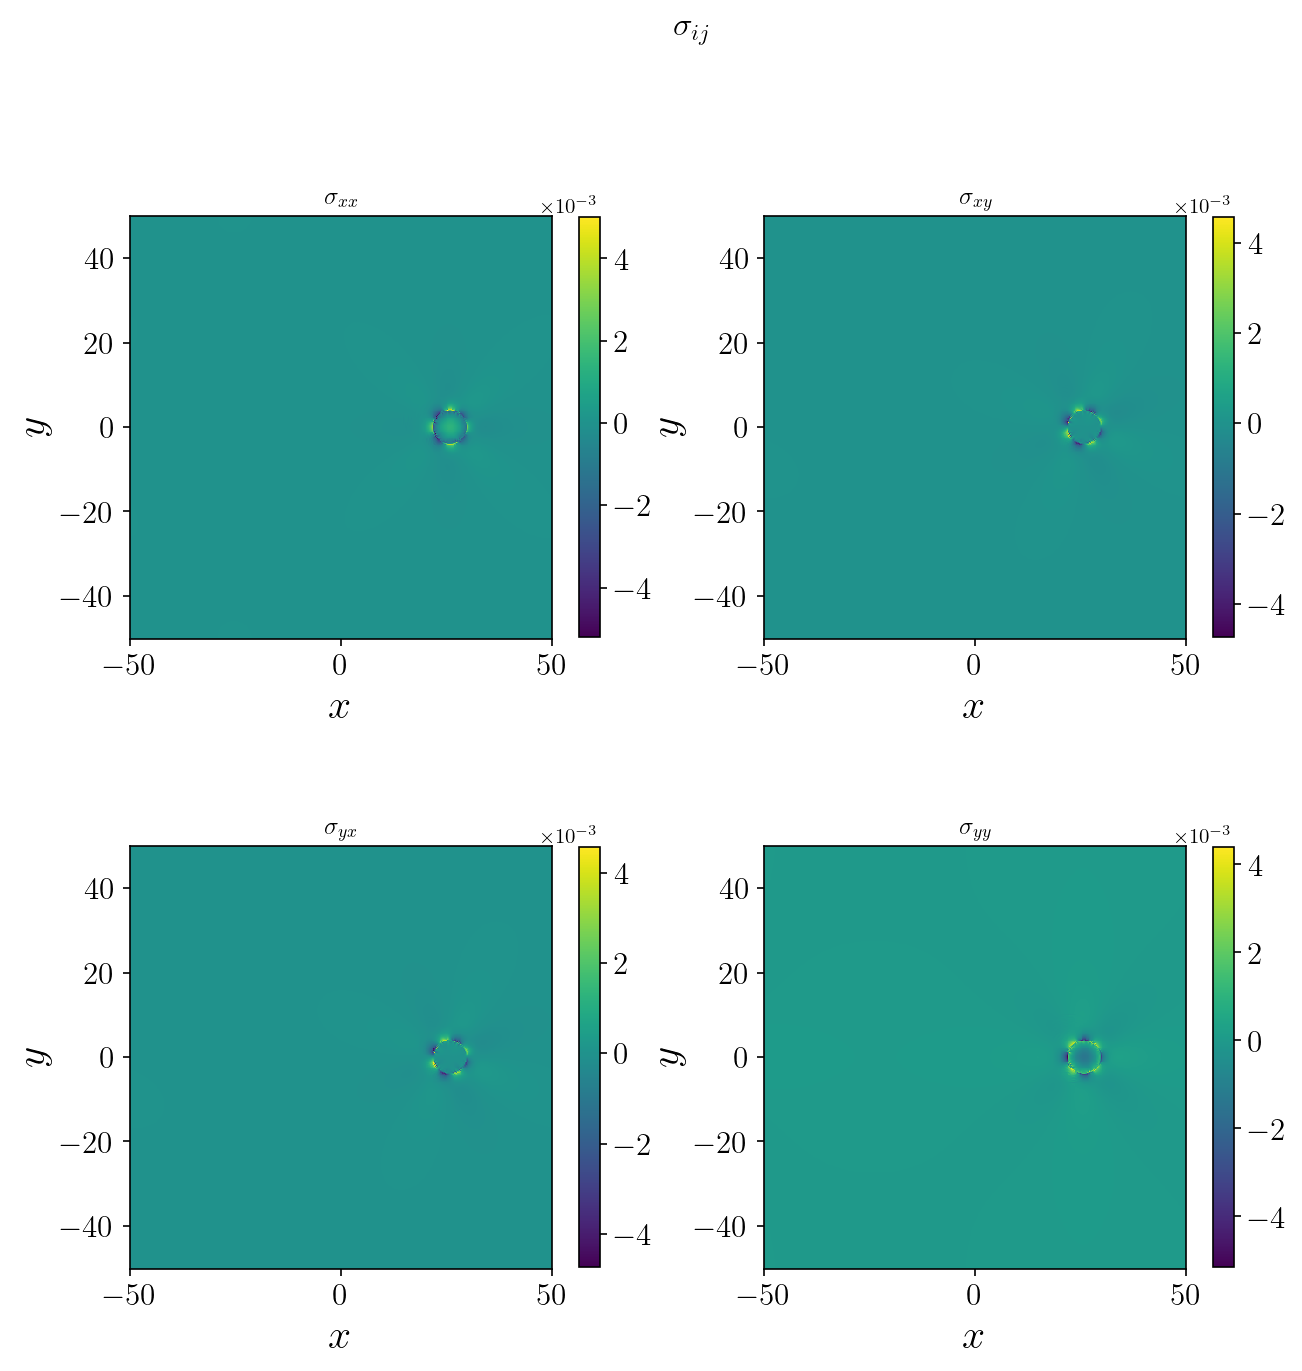

In [136]:
stressDf = pd.read_csv(dataDir + "stressTensor.csv").set_index(["id_x","id_y"]).sort_index()
fig, axes = aux.stressTensorOverview(stressDf)
plt.show()

# Animation

In [138]:
# necessary directories are created
outputDir = f"frames.{src_n}"
os.system(f'mkdir -p anims')
os.system(f'mkdir {outputDir}')

# the data is read and frames are saved
for tickId in np.arange(len(ticks)):
    fluidDf = pd.read_csv(dataDir + f"fluidTrj_{ticks[tickId]}.csv").set_index(["id_x","id_y"]).sort_index()
    title = "pusher, $\\beta = -5,$ "+f"$t = {fluidDf.time.values[0]:.0f}$"+" $\\mu \\mathrm{s}$"
    fig, axes = aux.fluidOverview(fluidDf.query("coordinate_x**2 <= 50**2 & coordinate_y**2 <= 13**2"), title)

    plt.savefig(f"{outputDir}/{tickId}.png", format="png", dpi=300, bbox_inches="tight")
    plt.close()
    print(f'\r{tickId}', end='', flush=True)
print('\r'+' '*10, end='', flush=True)

# ffmpeg is used to create the animation
mkAnimSh = f'ffmpeg -framerate 25 -i {outputDir}/%d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264 -pix_fmt yuv420p -loglevel quiet anims/src_{src_n}.mp4'
os.system(mkAnimSh)

# the directory with the frames is erased
os.system(f'rm -r {outputDir}')

0